In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Input, Multiply, TimeDistributed, Softmax, Lambda, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBClassifier
from tensorflow.keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib.gridspec as gridspec

def PFI_results(outcome_variable, outcome_name, outcome_col):
    ### Deep Learning analysis data preparation
    # Load data from a CSV file
    df = pd.read_csv('D:/Users/yipeng_wei/Documents/dl data/2025-04-18/df_dl_continous.csv')
    df_mask = pd.read_csv('D:/Users/yipeng_wei/Documents/dl data/2025-04-18/df_dl_continous_mask.csv')
    df_delta = pd.read_csv('D:/Users/yipeng_wei/Documents/dl data/2025-04-18/df_dl_continous_delta.csv')
    
    # Drop rows with NaN in the target column before any operations
    df = df.dropna(subset=[outcome_variable])
    df = df.reset_index(drop=True)
    
    df_mask = df_mask.dropna(subset=[outcome_variable])
    df_mask = df_mask.reset_index(drop=True)
    
    df_delta = df_delta.dropna(subset=[outcome_variable])
    df_delta = df_delta.reset_index(drop=True)
    
    features_categorical = ["TYPE_VISIT","SITE",
                "STILLBIRTH_IND","PRETERM_IND","CESARIAN_IND","NUM_MISCARRIAGE_ind",
                "DEPR_EVER",
                "PAID_WORK","GPARITY_2","GPARITY_1","WEALTH_QUINT_1","WEALTH_QUINT_2","WEALTH_QUINT_3","WEALTH_QUINT_4","SCHOOL_MORE10","WATER_IMPROVED","TOILET_IMPROVED","STOVE_FUEL","HH_SMOKE","SMOKE","CHEW_TOBACCO","CHEW_BETELNUT",
                "BMI_LEVEL_ENROLL_underweight","BMI_LEVEL_ENROLL_overweight","BMI_LEVEL_ENROLL_obese",
                "GWG_ADEQUACY_inadequate","GWG_ADEQUACY_excessive",
                "MAT_CES_ANY","BIRTH_FACILITY",
                "HTN","DIAB_OVERT_ANY","HIV_POSITIVE","TB_SYMP_POSITIVE","MAL_POSITIVE","HBV_POSITIVE_ENROLL","HCV_POSITIVE_ENROLL","STI_POSITIVE",
                "GES_HTN","DIAB_GEST_ANY",
                "INF_SEX","INF_HYPERBILI_NICE","BREASTFED",
                "NUM_FETUS_2","NUM_FETUS_3","INF_ANOMALY","PREVIA",
                "INF_PSBI_ANY"]
    
    features_continous = ["MAT_AGE","MUAC_ENROLL","GESTAGEBIRTH_ANY","BWEIGHT_ANY","CROWDING_IND",
                          "M01_AFI_PERES",
                          "M08_IRON_TOT_UGDL_LBORRES", "M08_FERRITIN_LBORRES","M08_IRON_HEP_LBORRES","M08_CBC_HB_LBORRES"]
    
    features_static = ["SITE",
                "STILLBIRTH_IND","PRETERM_IND","CESARIAN_IND","NUM_MISCARRIAGE_ind",
                "DEPR_EVER",
                "PAID_WORK","GPARITY_2","GPARITY_1","WEALTH_QUINT_1","WEALTH_QUINT_2","WEALTH_QUINT_3","WEALTH_QUINT_4","SCHOOL_MORE10","WATER_IMPROVED","TOILET_IMPROVED","STOVE_FUEL","HH_SMOKE","SMOKE","CHEW_TOBACCO","CHEW_BETELNUT","CROWDING_IND",
                "BMI_LEVEL_ENROLL_underweight","BMI_LEVEL_ENROLL_overweight","BMI_LEVEL_ENROLL_obese",
                "GWG_ADEQUACY_inadequate","GWG_ADEQUACY_excessive",
                "MAT_CES_ANY","BIRTH_FACILITY",
                "HTN","DIAB_OVERT_ANY","HIV_POSITIVE","TB_SYMP_POSITIVE","MAL_POSITIVE","HBV_POSITIVE_ENROLL","HCV_POSITIVE_ENROLL","STI_POSITIVE",
                "GES_HTN","DIAB_GEST_ANY",
                "INF_SEX","INF_HYPERBILI_NICE","BREASTFED","GESTAGEBIRTH_ANY","BWEIGHT_ANY",
                "INF_ANOMALY",
                "INF_PSBI_ANY",
                "NUM_FETUS_2","NUM_FETUS_3","MAT_AGE","MUAC_ENROLL"]
    
    features_temporal = ["TYPE_VISIT",
                         "M01_AFI_PERES",
                         "PREVIA",
                         "M08_IRON_TOT_UGDL_LBORRES","M08_FERRITIN_LBORRES","M08_IRON_HEP_LBORRES","M08_CBC_HB_LBORRES"]

    features_to_remove_by_outcome = {
        "STILLBIRTH_SIGNS_LIFE": ["INF_SEX","INF_HYPERBILI_NICE","BREASTFED","GESTAGEBIRTH_ANY","BWEIGHT_ANY","INF_PSBI_ANY","MAT_CES_ANY"],
        "PRETERMBIRTH_LT37": ["INF_HYPERBILI_NICE","BREASTFED","GESTAGEBIRTH_ANY","BWEIGHT_ANY","INF_PSBI_ANY","LABOR_ANY","PRO_LABOR","OBS_LABOR","MAT_CES_ANY","BIRTH_FACILITY"],
        "LBW2500_ANY": ["INF_HYPERBILI_NICE","BREASTFED","BWEIGHT_ANY","INF_PSBI_ANY","LABOR_ANY","PRO_LABOR","OBS_LABOR","MAT_CES_ANY","BIRTH_FACILITY"],
        "INF_PSBI_OUTCOME": ["INF_HYPERBILI_NICE","INF_PSBI_ANY","CESARIAN_IND","PREVIA"],
        "SVN": ["INF_SEX","INF_HYPERBILI_NICE","GESTAGEBIRTH_ANY","BWEIGHT_ANY","INF_PSBI_ANY","BREASTFED","LABOR_ANY","PRO_LABOR","OBS_LABOR","MAT_CES_ANY","BIRTH_FACILITY","CESARIAN_IND"],
        "NEARMISS": ["INF_SEX","INF_HYPERBILI_NICE","BREASTFED","GESTAGEBIRTH_ANY","BWEIGHT_ANY","INF_PSBI_ANY"]
        }

    features_clinical = ["BMI_LEVEL_ENROLL_underweight","BMI_LEVEL_ENROLL_overweight","BMI_LEVEL_ENROLL_obese",
         "GWG_ADEQUACY_inadequate","GWG_ADEQUACY_excessive",
         "GPARITY_2","GPARITY_1",
         "STILLBIRTH_IND","PRETERM_IND","CESARIAN_IND","NUM_MISCARRIAGE_ind",
         "HTN","DIAB_OVERT_ANY","GES_HTN","DIAB_GEST_ANY",
         "BIRTH_FACILITY","MAT_CES_ANY","INF_SEX","INF_HYPERBILI_NICE","BREASTFED","GESTAGEBIRTH_ANY","BWEIGHT_ANY","INF_PSBI_ANY","INF_ANOMALY"]
    
    features_ultrasound = ["M01_AFI_PERES","PREVIA","NUM_FETUS_2","NUM_FETUS_3"]
    
    features_labs = [
        "HIV_POSITIVE","TB_SYMP_POSITIVE","MAL_POSITIVE","HBV_POSITIVE_ENROLL","HCV_POSITIVE_ENROLL","STI_POSITIVE","M01_AFI_PERES",
        "M08_IRON_TOT_UGDL_LBORRES", "M08_FERRITIN_LBORRES","M08_IRON_HEP_LBORRES","M08_CBC_HB_LBORRES"]

    features_names_temporal = ["M01_AFI_PERES", "PREVIA",
                        "M08_IRON_TOT_UGDL_LBORRES", "M08_FERRITIN_LBORRES","M08_IRON_HEP_LBORRES","M08_CBC_HB_LBORRES",
                        "TYPE_VISIT_1", "TYPE_VISIT_2", "TYPE_VISIT_3", "TYPE_VISIT_4", "TYPE_VISIT_5"]
    
    features_names_static = [
                "STILLBIRTH_IND","PRETERM_IND","CESARIAN_IND","NUM_MISCARRIAGE_ind",
                "DEPR_EVER",
                "PAID_WORK","GPARITY_2","GPARITY_1","WEALTH_QUINT_1","WEALTH_QUINT_2","WEALTH_QUINT_3","WEALTH_QUINT_4","SCHOOL_MORE10","WATER_IMPROVED","TOILET_IMPROVED","STOVE_FUEL","HH_SMOKE","SMOKE","CHEW_TOBACCO","CHEW_BETELNUT","CROWDING_IND",
                "BMI_LEVEL_ENROLL_underweight","BMI_LEVEL_ENROLL_overweight","BMI_LEVEL_ENROLL_obese",
                "GWG_ADEQUACY_inadequate","GWG_ADEQUACY_excessive",
                "MAT_CES_ANY","BIRTH_FACILITY",
                "HTN","DIAB_OVERT_ANY","HIV_POSITIVE","TB_SYMP_POSITIVE","MAL_POSITIVE","HBV_POSITIVE_ENROLL","HCV_POSITIVE_ENROLL","STI_POSITIVE",
                "GES_HTN","DIAB_GEST_ANY",
                "INF_SEX","INF_HYPERBILI_NICE","BREASTFED","GESTAGEBIRTH_ANY","BWEIGHT_ANY",
                "INF_ANOMALY",
                "INF_PSBI_ANY",
                "NUM_FETUS_2","NUM_FETUS_3","MAT_AGE","MUAC_ENROLL",
                "SITE_Ghana", "SITE_India-CMC", "SITE_India-SAS", "SITE_Kenya", "SITE_Pakistan", "SITE_Zambia"]

    features_to_remove = features_to_remove_by_outcome.get(outcome_variable, [])
        
    # Remove features from the lists
    features_categorical = [f for f in features_categorical if f not in features_to_remove]
    features_continous = [f for f in features_continous if f not in features_to_remove]
    features_static = [f for f in features_static if f not in features_to_remove]
    features_temporal = [f for f in features_temporal if f not in features_to_remove]
    features_names_static = [f for f in features_names_static if f not in features_to_remove]
    features_names_temporal = [f for f in features_names_temporal if f not in features_to_remove]
    features_clinical = [f for f in features_clinical if f not in features_to_remove]
    features_ultrasound = [f for f in features_ultrasound if f not in features_to_remove]
    features_labs = [f for f in features_labs if f not in features_to_remove]

    # Separate categorical and continuous features
    df_categorical = df[features_categorical]
    df_continuous = df[features_continous]
    
    # Rescale continuous features to (0, 1) range
    scaler = MinMaxScaler()
    df_continuous_scaled = pd.DataFrame(scaler.fit_transform(df_continuous), columns=features_continous)
    
    # Concatenate scaled continuous features with categorical features
    X = pd.concat([df_categorical, df_continuous_scaled], axis=1)
        
    ##Static and temporal data
    X_static = X[features_static]
    
    X_temporal = X[features_temporal]
    X_temporal_delta = df_delta[features_temporal]
    X_temporal_mask = df_mask[features_temporal]
    
    y = df[outcome_variable]
    threshold = (df[outcome_variable] == 1).mean()
    
    # One-hot encoding for non-binary categorical features in X
    X = pd.get_dummies(X, columns=['TYPE_VISIT','SITE'], dummy_na=False)
    X_static = pd.get_dummies(X_static, columns=['SITE'], dummy_na=False)
    X_temporal = pd.get_dummies(X_temporal, columns=['TYPE_VISIT'], dummy_na=False)
    X_temporal_delta = pd.get_dummies(X_temporal_delta, columns=['TYPE_VISIT'], dummy_na=False)
    X_temporal_mask = pd.get_dummies(X_temporal_mask, columns=['TYPE_VISIT'], dummy_na=False)
    
    # Preprocess for Keras models (3D matrix)
    n_samples = X_temporal.shape[0] // 5 
    X_static_keras = X_static.iloc[::5].values.astype('float32')
    
    X_temporal_keras = X_temporal.values.reshape(n_samples, 5, X_temporal.shape[1]).astype('float32')
    X_temporal_delta_keras = X_temporal_delta.values.reshape(n_samples, 5, X_temporal_delta.shape[1]).astype('float32')
    X_temporal_mask_keras = X_temporal_mask.values.reshape(n_samples, 5, X_temporal_mask.shape[1]).astype('float32')
    
    X_keras = X.values.reshape(n_samples, 5, X.shape[1]).astype('float32')
    
    # Align y for Keras models
    y_keras = y.iloc[::5].values.astype('float32')
    
    #### GRUD With Static Attention
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from sklearn.model_selection import KFold
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    import numpy as np
    
    class GRUDWithStaticAttention(nn.Module):
            def __init__(self, input_size, hidden_size, output_size, mean_values, static_input_size, static_embedding_size, dropout_rate=0.5):
                """
                GRU-D model with attention mechanism generated from static data.
                
                Args:
                    input_size (int): Number of input features for temporal data.
                    hidden_size (int): Number of hidden units in GRU.
                    output_size (int): Number of output classes (for classification tasks).
                    mean_values (torch.Tensor): Empirical mean values for each input feature.
                    static_input_size (int): Number of input features for static data.
                    static_embedding_size (int): Size of the embedding for static data.
                """
                super(GRUDWithStaticAttention, self).__init__()
                
                # Temporal (GRU-D) parameters
                self.input_size = input_size
                self.hidden_size = hidden_size
                self.output_size = output_size
                
                self.mean_values = mean_values
                
                self.gamma_x = nn.Linear(input_size, input_size)
                
                # GRU gate parameters (temporal part) with combined input, hidden state, and mask
                self.zl = nn.Linear(input_size + hidden_size + input_size, hidden_size)  # Update gate
                self.rl = nn.Linear(input_size + hidden_size + input_size, hidden_size)  # Reset gate
                self.hl = nn.Linear(input_size + hidden_size + input_size, hidden_size)  # Candidate hidden state
        
                # Embedding or processing static data
                self.static_fc = nn.Linear(static_input_size, static_embedding_size)
        
                # Attention mechanism based on static data
                self.attention = nn.Linear(static_embedding_size, hidden_size)
        
                # Fully connected output layer
                self.dropout = nn.Dropout(dropout_rate)
                self.concat_fc = nn.Linear(hidden_size + static_embedding_size, output_size)
    
        
            def forward(self, x, m, delta, static_data):
                """
                Forward pass of GRU-D with static data attention.
                
                Args:
                    x (torch.Tensor): Temporal input data [batch_size, seq_len, input_size].
                    m (torch.Tensor): Masking vector [batch_size, seq_len, input_size].
                    delta (torch.Tensor): Time intervals [batch_size, seq_len, input_size].
                    static_data (torch.Tensor): Static data input [batch_size, static_input_size].
                """
                batch_size, seq_len, _ = x.size()
                
                # Process static data to generate attention weights
                static_embed = torch.relu(self.static_fc(static_data))  # [batch_size, static_embedding_size]
                
                # Generate attention weights from static data
                attention_weights = torch.sigmoid(self.attention(static_embed))  # [batch_size, hidden_size]
                
                # Initialize hidden state
                h = torch.zeros(batch_size, self.hidden_size).to(x.device)
                
                for t in range(seq_len):
                    # Corrected input decay mechanism
                    gamma_x_t = torch.exp(-F.relu(self.gamma_x(delta[:, t, :])))
                    x_t_hat = m[:, t, :] * x[:, t, :] + (1 - m[:, t, :]) * (gamma_x_t * self.mean_values + (1 - gamma_x_t) * x[:, t, :])
                    
                    # Concatenate input, hidden state, and mask
                    combined = torch.cat([x_t_hat, h, m[:, t, :]], dim=-1)
        
                    # GRU gates
                    r_t = torch.sigmoid(self.rl(combined))  # Reset gate
                    z_t = torch.sigmoid(self.zl(combined))  # Update gate
                    h_tilde = torch.tanh(self.hl(torch.cat([x_t_hat, r_t * h, m[:, t, :]], dim=-1)))  # Candidate hidden state
        
                    # Update hidden state
                    h = (1 - z_t) * h + z_t * h_tilde
        
                # Apply attention weights to the final hidden state
                h_weighted = attention_weights * h  # [batch_size, hidden_size]
    
                h_concat = self.dropout(torch.cat([h_weighted, static_embed], dim=-1))  # [B, hidden + static_embedding_size]
            
                output = torch.sigmoid(self.concat_fc(h_concat)) 
                return output
    
    # Training Parameters
    input_size = X_temporal_keras.shape[2]  # Temporal input features
    hidden_size = 32  # GRU hidden state size
    output_size = 1  # Binary classification
    static_input_size = X_static_keras.shape[1]  # Static input features
    static_embedding_size = 32  # Embedding size for static features
    mean_values = torch.tensor(np.nanmean(X_temporal_keras, axis=(0, 1)), dtype=torch.float32)  # Temporal feature means
    
    
    # Convert data to PyTorch tensors
    x = torch.tensor(X_temporal_keras, dtype=torch.float32)  # Temporal input
    mask = torch.tensor(X_temporal_mask_keras, dtype=torch.float32)  # Masking vector
    delta = torch.tensor(X_temporal_delta_keras, dtype=torch.float32)  # Time intervals
    static_data = torch.tensor(X_static_keras, dtype=torch.float32)  # Static input
    y = torch.tensor(y_keras, dtype=torch.float32)  # Binary labels
    
    X_tensor = torch.tensor(X_temporal_keras, dtype=torch.float32)  # Temporal input
    mask_tensor = torch.tensor(X_temporal_mask_keras, dtype=torch.float32)  # Masking vector
    delta_tensor = torch.tensor(X_temporal_delta_keras, dtype=torch.float32)  # Time intervals
    static_tensor = torch.tensor(X_static_keras, dtype=torch.float32)  # Static input (2D)
    y_tensor = torch.tensor(y_keras, dtype=torch.float32)  # Labels
    
    # Define test size (e.g., 20% test, 80% train)
    test_size = 0.2
    
    # Define model hyperparameters
    input_size = X_tensor.shape[2]  # Number of temporal features
    hidden_size = 64  # Number of hidden units in GRU
    output_size = 1  # Binary classification
    static_input_size = static_tensor.shape[1]  # Number of static features
    static_embedding_size = 16  # Embedding size for static features
    mean_values = torch.tensor(np.nanmean(X_temporal_keras, axis=(0, 1)), dtype=torch.float32)  # Temporal feature means
    
    # Initialize the model
    grud_static_model = GRUDWithStaticAttention(
        input_size=input_size,
        hidden_size=hidden_size,
        output_size=output_size,
        mean_values=mean_values,
        static_input_size=static_input_size,
        static_embedding_size=static_embedding_size
    )
    
    # Perform the train-test split (CPU-only)
    X_train, X_test, mask_train, mask_test, delta_train, delta_test, static_train, static_test, y_train, y_test = train_test_split(
        X_tensor, mask_tensor, delta_tensor, static_tensor, y_tensor, test_size=test_size, random_state=42
    )
    
    
    # Initialize model
    grud_static_model.train()
    
    # Define loss and optimizer
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(grud_static_model.parameters(), lr=0.01)
    
    # Training loop (CPU-only)
    n_epochs = 100  # Adjust based on performance
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = grud_static_model(X_train, mask_train, delta_train, static_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
    # Set model to evaluation mode
    grud_static_model.eval()
    
    def compute_pfi_temporal_avg(model, X_test, mask_test, delta_test, static_test, y_test, n_repeats, metric=roc_auc_score):
        """
        Computes permutation feature importance (PFI) on test data for temporal features,
        averaging over multiple runs for improved stability (CPU-only).
        """
        model.eval()  # Set model to evaluation mode
    
        # Compute baseline model predictions
        with torch.no_grad():
            y_pred = model(X_test, mask_test, delta_test, static_test).numpy()
    
        baseline_score = metric(y_test.numpy(), y_pred)
    
        num_features = X_test.shape[2]  # Number of temporal features
        feature_importance = np.zeros(num_features)  # Store mean importance
    
        for _ in range(n_repeats):  # Repeat multiple times
            temp_importance = []
            for i in range(num_features):
                X_perm = X_test.clone()
                idx = torch.randperm(X_perm.shape[0])  # Shuffle across batch dimension
                X_perm[:, :, i] = X_perm[idx, :, i]  # Shuffle only feature `i`
                
                with torch.no_grad():
                    y_pred_perm = model(X_perm, mask_test, delta_test, static_test).numpy()
                
                score = metric(y_test.numpy(), y_pred_perm)
                temp_importance.append(baseline_score - score)  # Compute importance
            
            feature_importance += np.array(temp_importance)  # Accumulate importance scores
    
        return feature_importance / n_repeats  # Return average importance
    
    def compute_pfi_static_avg(model, X_test, mask_test, delta_test, static_test, y_test, n_repeats, metric=roc_auc_score):
        """
        Computes permutation feature importance (PFI) on test data for static features,
        averaging over multiple runs for improved stability (CPU-only).
        """
        model.eval()
    
        # Compute baseline model predictions
        with torch.no_grad():
            y_pred = model(X_test, mask_test, delta_test, static_test).numpy()
    
        baseline_score = metric(y_test.numpy(), y_pred)
    
        num_features = static_test.shape[1]  # Number of static features
        feature_importance = np.zeros(num_features)  # Store mean importance
    
        for _ in range(n_repeats):  # Repeat multiple times
            temp_importance = []
            for i in range(num_features):
                static_perm = static_test.clone()
                idx = torch.randperm(static_perm.shape[0])  # Shuffle across batch dimension
                static_perm[:, i] = static_perm[idx, i]  # Shuffle only feature `i`
                
                with torch.no_grad():
                    y_pred_perm = model(X_test, mask_test, delta_test, static_perm).numpy()
                
                score = metric(y_test.numpy(), y_pred_perm)
                temp_importance.append(baseline_score - score)  # Compute importance
            
            feature_importance += np.array(temp_importance)  # Accumulate importance scores
    
        return feature_importance / n_repeats  # Return average importance
    
    # Define number of repeats for stability
    n_repeats = 200
    
    # Compute feature importance (averaged over multiple runs)
    perm_importance_temporal_avg = compute_pfi_temporal_avg(grud_static_model, X_test, mask_test, delta_test, static_test, y_test, n_repeats=n_repeats)
    perm_importance_static_avg = compute_pfi_static_avg(grud_static_model, X_test, mask_test, delta_test, static_test, y_test, n_repeats=n_repeats)
    
    # Convert to NumPy
    perm_importance_temporal_avg = np.array(perm_importance_temporal_avg)
    perm_importance_static_avg = np.array(perm_importance_static_avg)
    
    # Ensure correct feature-name alignment
    assert len(features_names_temporal) == len(perm_importance_temporal_avg), "Mismatch: Temporal feature names and importance scores."
    assert len(features_names_static) == len(perm_importance_static_avg), "Mismatch: Static feature names and importance scores."
    
    # Combine temporal & static feature names and importance scores
    all_feature_names = features_names_temporal + features_names_static
    all_importance_scores = np.concatenate([perm_importance_temporal_avg, perm_importance_static_avg])
    
    excluded_features = [
        "SITE_Ghana", "SITE_India-CMC", "SITE_India-SAS", "SITE_Kenya", "SITE_Pakistan", "SITE_Zambia",
        "TYPE_VISIT_1", "TYPE_VISIT_2", "TYPE_VISIT_3", "TYPE_VISIT_4", "TYPE_VISIT_5",
        "M01_AFI_PERES", "PREVIA", "M08_IRON_TOT_UGDL_LBORRES", "M08_FERRITIN_LBORRES","M08_IRON_HEP_LBORRES","M08_CBC_HB_LBORRES"
    ]
    
        # Filter before sorting
    filtered_pairs = [
        (score, name) for score, name in zip(all_importance_scores, all_feature_names)
        if name not in excluded_features
    ]
    
    # Sort and select top 10
    sorted_features = sorted(filtered_pairs, reverse=True)[:10]
    sorted_importance, sorted_feature_names = zip(*sorted_features)
    
    variable_labels = {
    # === Temporal Labs & Clinical ===
    "M01_AFI_PERES": "Amniotic Fluid Index (AFI)",
    "PREVIA": "Placental Previa Anomalies",
    "M08_IRON_TOT_UGDL_LBORRES": "Serum Iron (µg/dL)",
    "M08_FERRITIN_LBORRES": "Ferritin (ng/mL)",
    "M08_IRON_HEP_LBORRES": "Hepcidin (ng/mL)",
    "M08_CBC_HB_LBORRES": "Hemoglobin (g/dL)",
    
    # === Pregnancy History ===
    "STILLBIRTH_IND": "Stillbirth History",
    "PRETERM_IND": "Preterm Birth History",
    "CESARIAN_IND": "Cesarean Delivery History",
    "NUM_MISCARRIAGE_ind": "Previous Miscarriages >= 3",
    
    # === Socioeconomic & Demographics ===
    "DEPR_EVER": "Maternal Depression",
    "PAID_WORK": "Paid Work",
    "GPARITY_1": "Parous (1-4)",
    "GPARITY_2": "Grand Multiparous (>=5)",
    "WEALTH_QUINT_1": "Wealth Quintile 1 (Poorest)",
    "WEALTH_QUINT_2": "Wealth Quintile 2 (Poor)",
    "WEALTH_QUINT_3": "Wealth Quintile 3 (Middle)",
    "WEALTH_QUINT_4": "Wealth Quintile 4 (Rich)",
    "SCHOOL_MORE10": "Schooling >= 10 Years",
    "WATER_IMPROVED": "Improved Water",
    "TOILET_IMPROVED": "Improved Toilet",
    "STOVE_FUEL": "Clean Stove Fuel",
    "HH_SMOKE": "Household Smoking",
    "SMOKE": "Smoking",
    "CHEW_TOBACCO": "Chews Tobacco",
    "CHEW_BETELNUT": "Chews Betel Nut",
    "CROWDING_IND": "Crowding Index",
    
    # === Delivery ===
    "MAT_CES_ANY": "Cesarean Delivery",
    "BIRTH_FACILITY": "Delivered at Facility",
        
    # === Comorbidities ===
    "HTN": "Hypertension (Chronic)",
    "DIAB_OVERT_ANY": "Overt Diabetes",
    "HIV_POSITIVE": "HIV Positive",
    "TB_SYMP_POSITIVE": "TB Symptoms",
    "MAL_POSITIVE": "Malaria Positive",
    "HBV_POSITIVE_ENROLL": "Hepatitis B Positive (Enrollment)",
    "HCV_POSITIVE_ENROLL": "Hepatitis C Positive (Enrollment)",
    "STI_POSITIVE": "Any STI Positive",
    
    # === Comorbidities during ANC ===
    "GES_HTN": "Gestational Hypertension",
    "DIAB_GEST_ANY": "Gestational Diabetes",
    
    # === Infant Outcomes ===
    "INF_SEX": "Infant Sex",
    "INF_HYPERBILI_NICE": "TCB exceeds NICE threshold (IPC-PNC1)",
    "BREASTFED": "Exclusively Breastfed",
    "GESTAGEBIRTH_ANY": "Gestational Age at Birth",
    "BWEIGHT_ANY": "Birthweight",
    "INF_ANOMALY": "Congenital Anomaly",
    "INF_PSBI_ANY": "PSBI",
    
    # === Ultrasound Static ===
    "NUM_FETUS_2": "Twin Pregnancy",
    "NUM_FETUS_3": "Triplet Pregnancy",
    
    # === Maternal Characteristics ===
    "MAT_AGE": "Maternal Age (Years)",
    "MUAC_ENROLL": "MUAC at Enrollment (cm)",
    
    # === BMI & Weight Gain ===
    "BMI_LEVEL_ENROLL_underweight": "BMI Underweight (<18.5)",
    "BMI_LEVEL_ENROLL_overweight": "BMI Overweight (25-29.9)",
    "BMI_LEVEL_ENROLL_obese": "BMI Obese (>=30)",
    "GWG_ADEQUACY_inadequate": "Inadequate GWG",
    "GWG_ADEQUACY_excessive": "Excessive GWG",
    }

    sorted_feature_labels = [variable_labels.get(f, f) for f in sorted_feature_names]

     # Assign colors based on feature category
    colors = []
    for feature in sorted_feature_names:
        if feature in features_ultrasound:
            colors.append("#FFD580")  # Ultrasound Features (Orange)
        elif feature in features_labs:
            colors.append("lightcoral")  # Lab Features (Red)
        elif feature in features_clinical:
            colors.append("purple")  # Clicical Features (Purple)
        else:
            colors.append("royalblue")  # Basic Features (Blue)

    from matplotlib.ticker import ScalarFormatter
    
    # === Load OR results ===
    df_or = pd.read_excel('D:/Users/yipeng_wei/Documents/Output/DL/Odds_results_adjusted.xlsx')
    
    # Keep only rows with a valid Risk_Factor and non-NA OR(CI)
    df_or_clean = df_or[df_or["Risk_Factor"].notna() & df_or[outcome_col].notna()].copy()
    
    # Parse OR, CI lower, CI upper using regex
    def parse_or_ci(value):
        match = re.match(r"([0-9.]+)\s*\(([^,]+),\s*([^)]+)\)", str(value))
        if match:
            or_val = float(match.group(1))
            ci_low = float(match.group(2))
            ci_up  = float(match.group(3))
            return pd.Series([or_val, ci_low, ci_up])
        else:
            return pd.Series([None, None, None])
    
    df_or_clean[["OR", "CI_lower", "CI_upper"]] = df_or_clean[outcome_col].apply(parse_or_ci)
    
    # Rename for clarity
    df_or_clean = df_or_clean[["Risk_Factor", "OR", "CI_lower", "CI_upper"]]
    
    # Match and order OR data to the top 10 PFI features
    df_or_top = df_or_clean[df_or_clean["Risk_Factor"].isin(sorted_feature_labels)].copy()
    df_or_top["y_order"] = df_or_top["Risk_Factor"].apply(lambda x: sorted_feature_labels.index(x))
    df_or_top = df_or_top.sort_values("y_order").reset_index(drop=True)
    
    # Values for plotting
    or_vals = df_or_top["OR"].values
    ci_lower = df_or_top["CI_lower"].values
    ci_upper = df_or_top["CI_upper"].values
    
    # Compute error bars in log space → ensures symmetry
    log_or = np.log(or_vals)
    log_ci_lower = np.log(ci_lower)
    log_ci_upper = np.log(ci_upper)
    error_bars = [or_vals - ci_lower, ci_upper - or_vals]
    
    # === Set up dual panel plot ===
    fig, (ax1, ax0) = plt.subplots(
        1, 2, figsize=(15, 8),
        gridspec_kw={'width_ratios': [2, 1.3]}, sharey=True
    )
    
    y_pos = np.arange(len(sorted_feature_labels))
    
    # === LEFT: PFI ===
    ax1.barh(y_pos, sorted_importance, color=colors)
    for i, value in enumerate(sorted_importance):
        ax1.text(value + 0.002, i, f"{value:.3f}", va='center', ha='left', fontsize=14)
    
    ax1.set_xlabel("Importance Score (Drop in AUC)", fontsize=18)
    ax1.set_title(f"{outcome_name}: Permutation Feature Importance", fontsize=18)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(sorted_feature_labels, fontsize=16)
    ax1.invert_yaxis()
    
    # === RIGHT: OR + 95% CI ===
    # Plot odds ratios with symmetric CIs on log scale
    ax0.errorbar(
        or_vals, y_pos,
        xerr=error_bars,
        fmt='o', color='black', ecolor='gray', capsize=4
    )
    
    # Reference line at OR = 1
    ax0.axvline(1, linestyle='--', color='red')
    
    # Set log scale
    ax0.set_xscale("log")
    
    # Choose more intuitive ticks
    tick_vals = [0.1, 0.25, 0.5, 1, 2, 5, 10]
    ax0.set_xticks(tick_vals)
    
    # Show integer/fraction values
    ax0.xaxis.set_major_formatter(ScalarFormatter())
    
    # Axis labels/titles
    ax0.set_xlabel("Odds Ratio (95% CI)", fontsize=18)
    ax0.set_title("Adjusted Odds Ratios", fontsize=18)
    ax0.tick_params(axis='y', labelleft=False)
    # Grid: only major ticks
    ax0.grid(True, axis='x', which="major")
    ax0.grid(False, axis='x', which="minor")
    
    # === Legend ===
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FFD580', label='Ultrasound'),
        Patch(facecolor='lightcoral', label='Lab'),
        Patch(facecolor='purple', label='Clinical'),
        Patch(facecolor='royalblue', label='Sociodemographics')
    ]
    ax1.legend(handles=legend_elements, loc="lower right", fontsize=16)
    
    plt.tight_layout()
    plt.show()


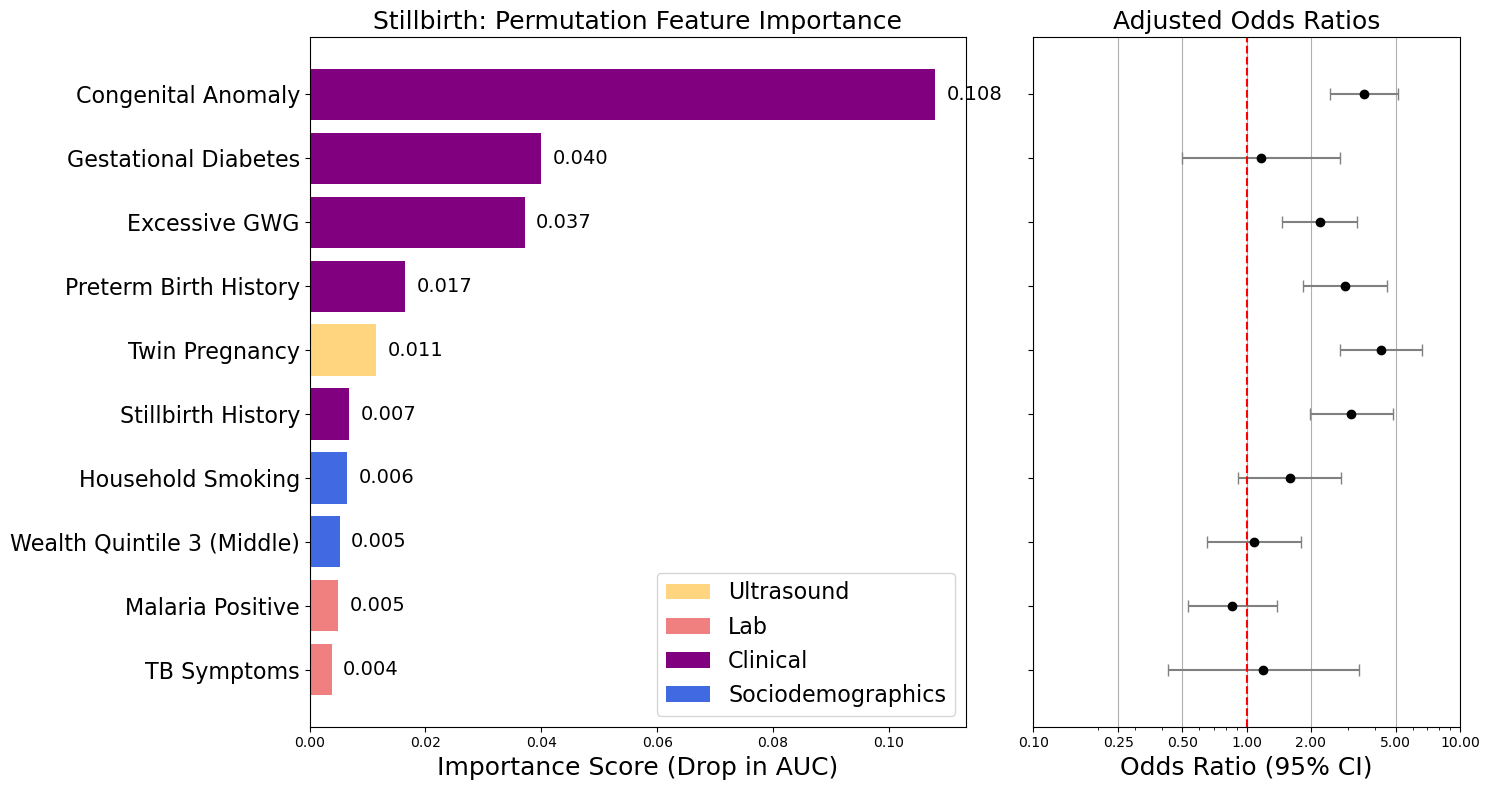

In [2]:
PFI_results("STILLBIRTH_SIGNS_LIFE","Stillbirth","Stillbirth OR (CI)")

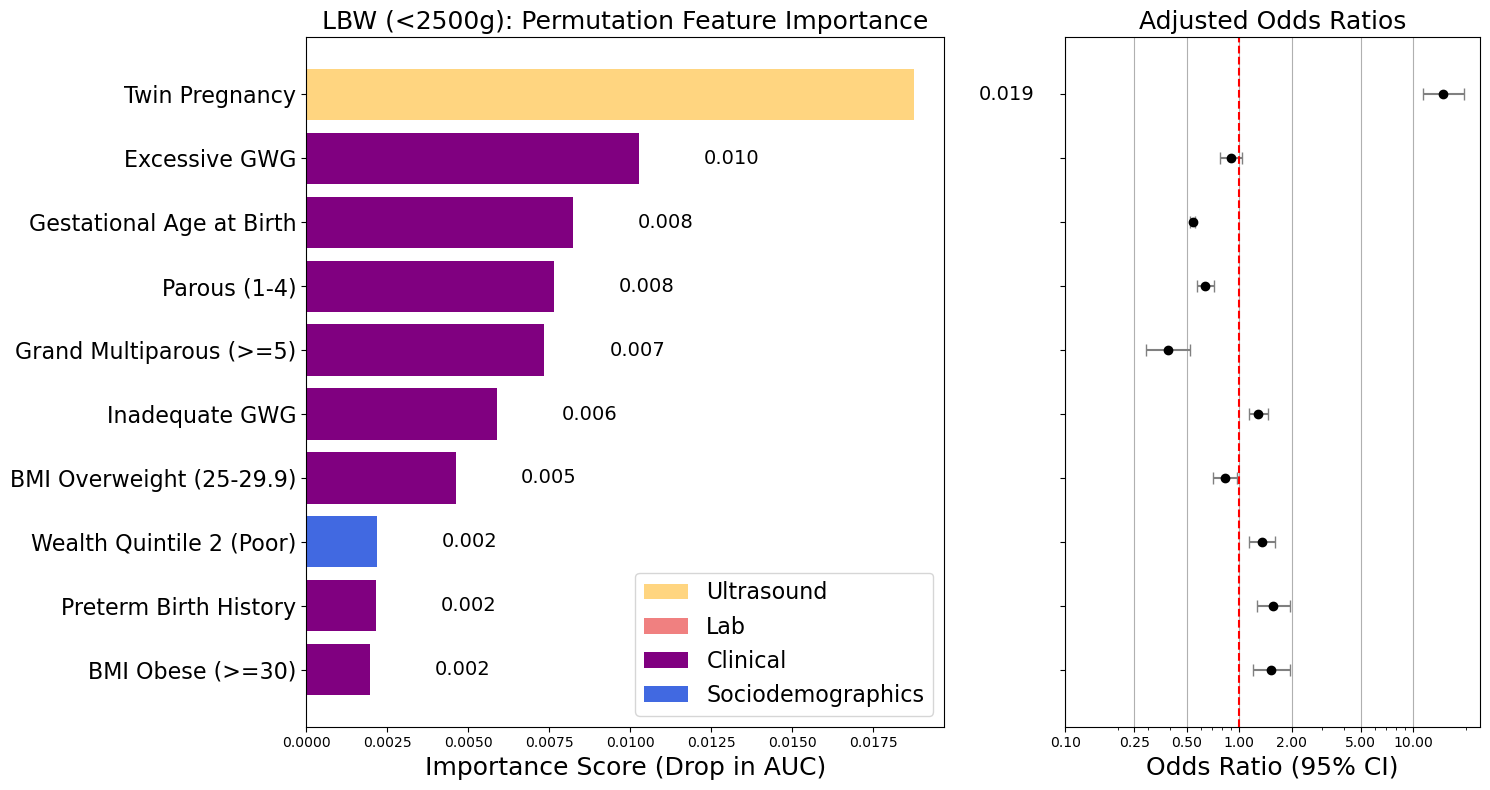

In [3]:
PFI_results("LBW2500_ANY","LBW (<2500g)", "LBW OR (CI)")

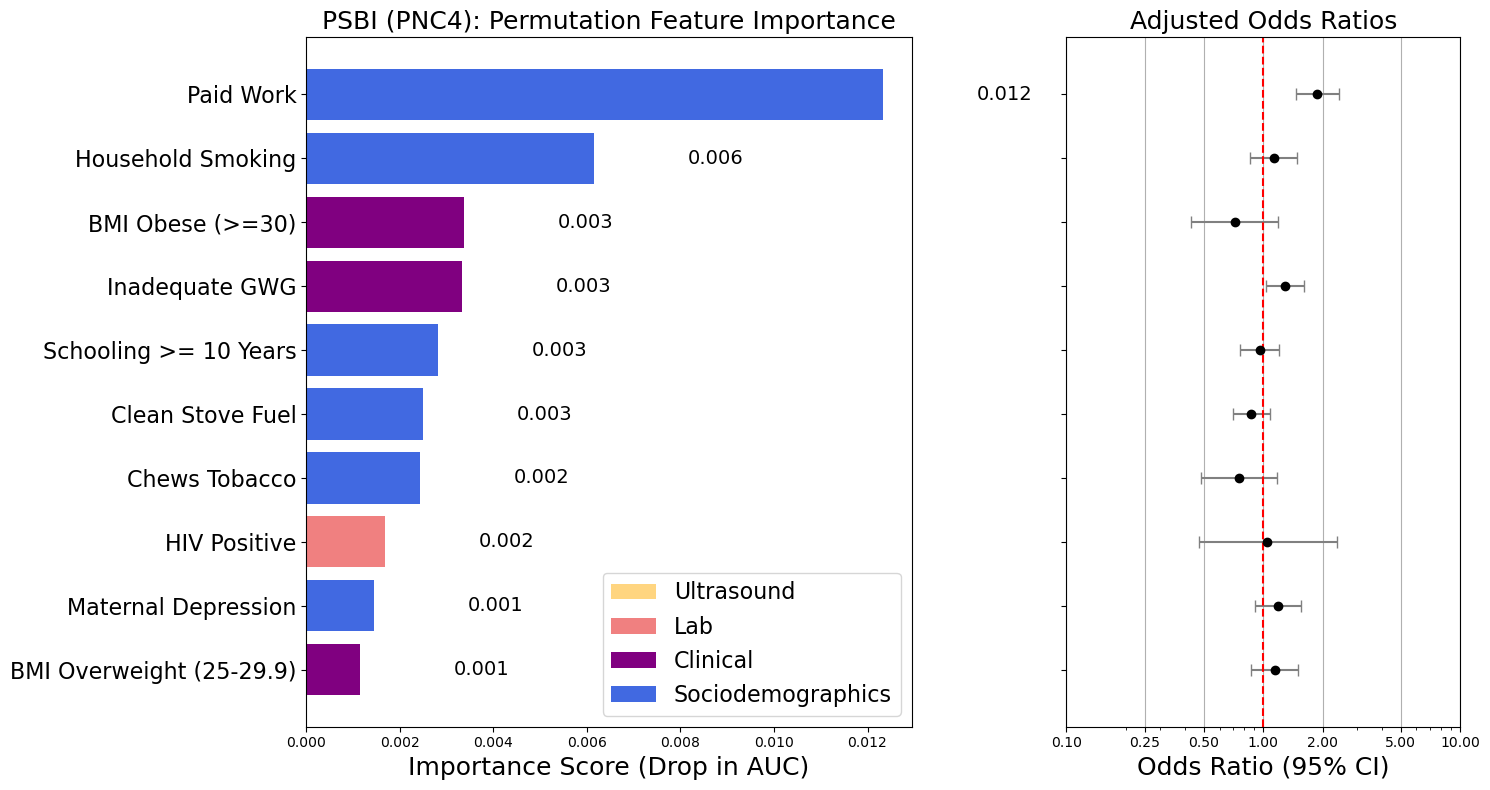

In [4]:
PFI_results("INF_PSBI_OUTCOME","PSBI (PNC4)", "PSBI OR (CI)")

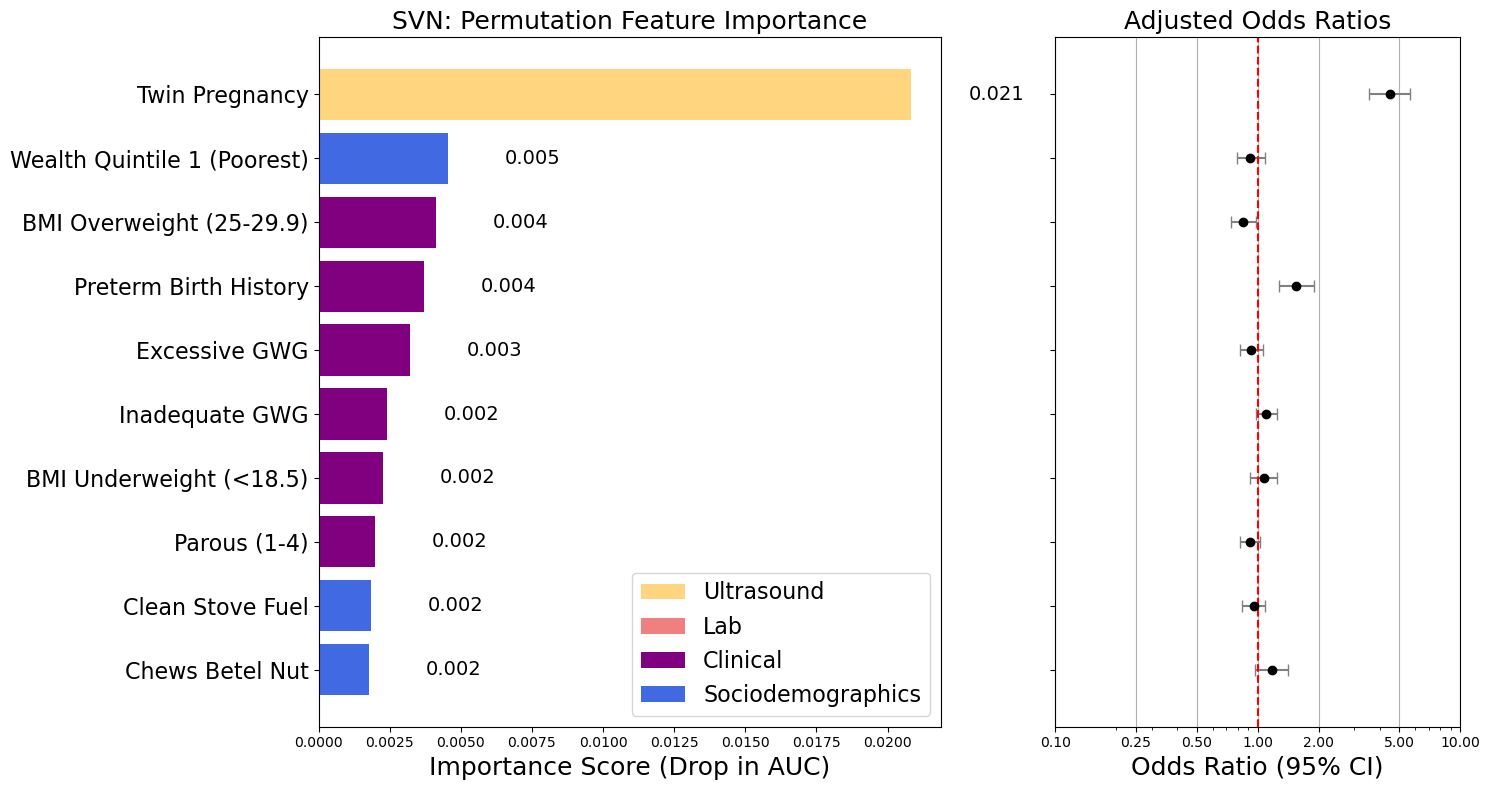

In [5]:
PFI_results("SVN","SVN","SVN OR (CI)")

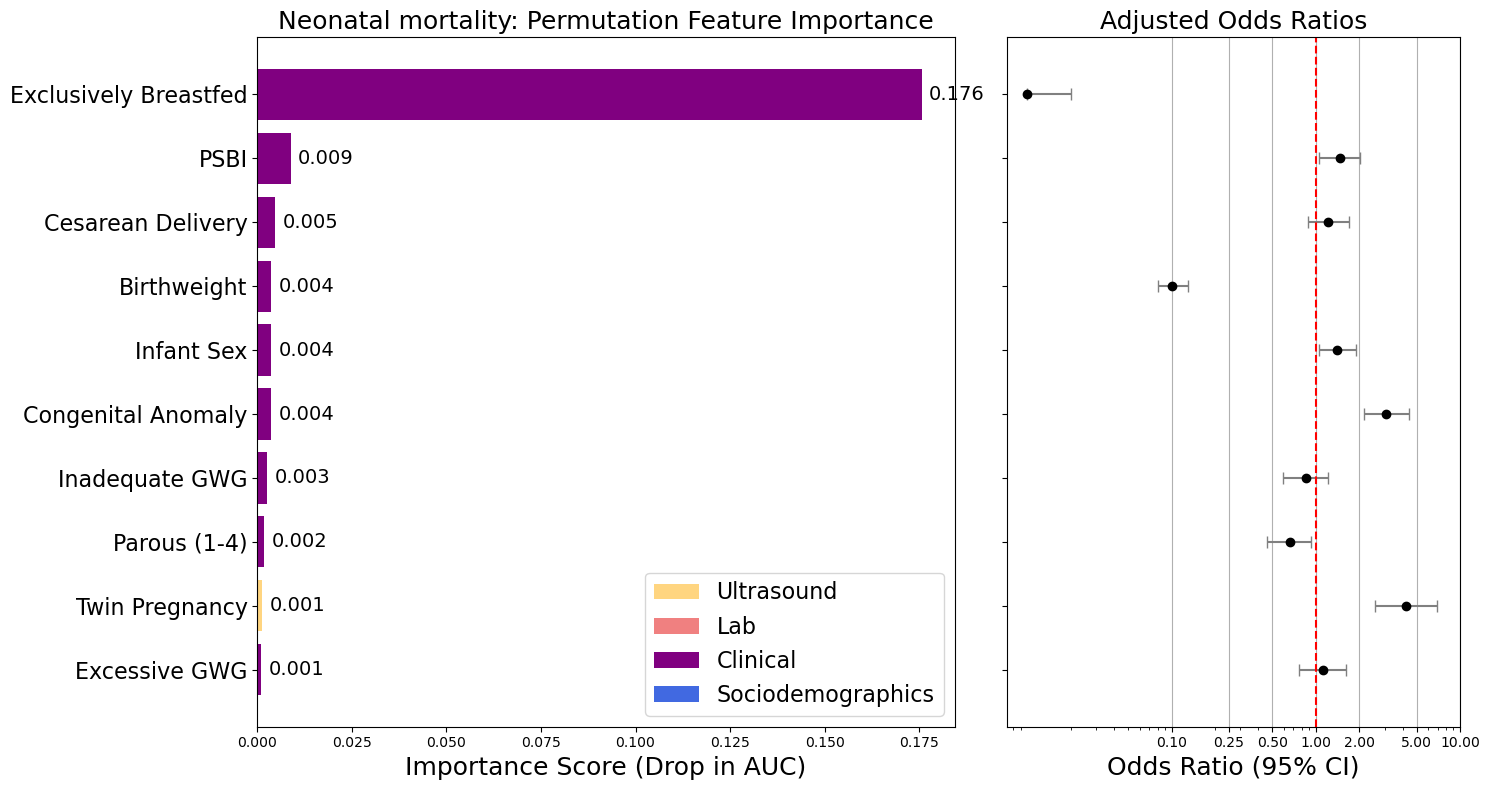

In [6]:
PFI_results("NEO_DTH","Neonatal mortality","Neonatal Death OR (CI)")

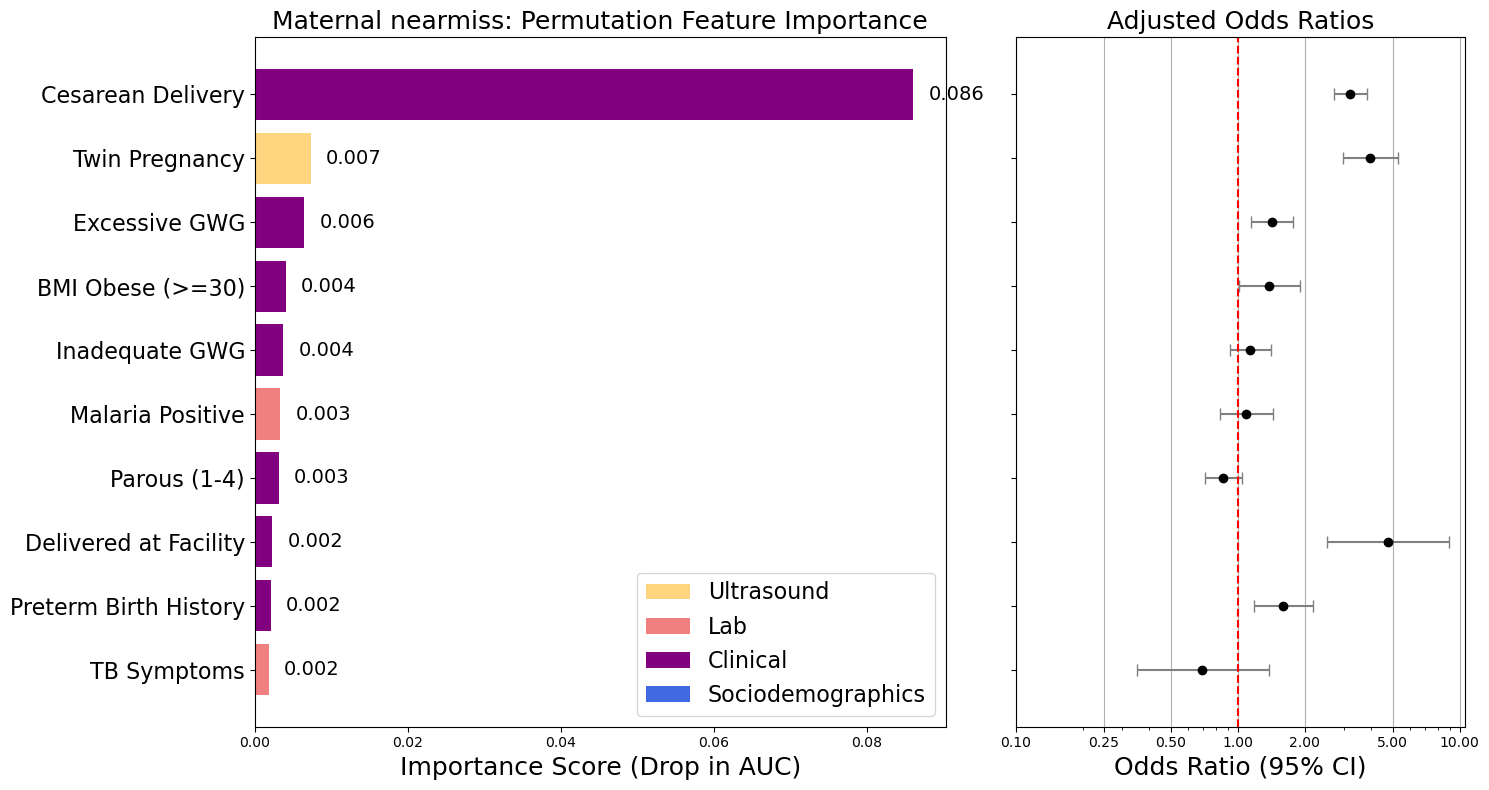

In [7]:
PFI_results("NEARMISS","Maternal nearmiss","Near Miss OR (CI)")